# Sensing with GLOW

In [3]:
import torch, os
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.autograd import Variable
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim

Only to link the Drive to Colab

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive #PATH IN THE DRIVE 

Mounted at /content/drive
[Errno 2] No such file or directory: 'drive/MyDrive#PATH IN THE DRIVE'
/content


*According to this paper : <a href="https://arxiv.org/pdf/1807.03039.pdf">Generative Flow with Invertible Convolutions</a>*
    
*And according to this <a href="https://github.com/rosinality/glow-pytorch">Github</a> for the model*

In [8]:
from model_glow import Glow

### Load Data & Model

In [9]:
batch_size = 2

In [10]:
IMAGE_PATH = 'data/ood'

#For GLOW training : 200 000 first images of CelebA
#For the test : the last ones (or faces from another dataset)

In [11]:
image_size = 64

transform = transforms.Compose([
    transforms.Scale(image_size),
    transforms.CenterCrop((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (1, 1, 1))
])

dataset = ImageFolder(IMAGE_PATH, transform)
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

print('Data Loaded !')

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


Data Loaded !


In [12]:
model_single = Glow(3, 32, 4, affine=False, conv_lu=True)
model = nn.DataParallel(model_single)
model.load_state_dict(torch.load('models/model_glow.pt'))

print('Model Loaded !')

/content/drive/MyDrive/Stage Supaero/model_glow.py:102: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  w_s = torch.from_numpy(w_s)


Model Loaded !


In [13]:
## UTILS

def denorm(x):
    out = (x + 0.5)
    return out.clamp(0, 1)

def calc_z_shapes(n_channel, input_size, n_flow, n_block):
    z_shapes = []

    for i in range(n_block - 1):
        input_size //= 2
        n_channel *= 2

        z_shapes.append((n_channel, input_size, input_size))

    input_size //= 2
    z_shapes.append((n_channel * 4, input_size, input_size))

    return z_shapes

    ######################################

def PSNR(x,y):

    x_ = 255*x.view(-1).detach().cpu()
    y_ = 255*y.view(-1).detach().cpu()
    MSE = torch.nn.MSELoss(reduction = 'mean')
    #print(MSE(x_,y_))

    return (10*torch.log10(255*255/MSE(x_,y_))).item()

def SSIM(x, y):

    img_1 = x[0].detach().cpu().numpy()
    img_2 = y[0].detach().cpu().numpy()

    return ssim(np.transpose(img_1,(1,2,0)), np.transpose(img_2,(1,2,0)), data_range=img_2.max() - img_2.min(), multichannel=True)

def SAD(x, y):

    img_1 = x.detach().cpu().numpy()
    img_2 = y.detach().cpu().numpy()

    return np.sum(img_1*img_2)/np.sqrt(np.sum(img_1**2) * np.sum(img_2**2))

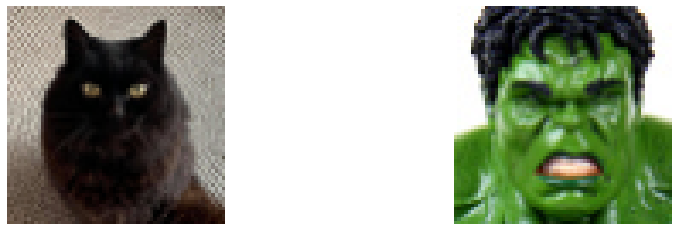

In [14]:
images, _ = next(iter(data_loader))
    
img = Variable(images)
image = np.transpose(denorm(img).detach().numpy(),(0,2,3,1))

n = image.shape[0]
fig, ax = plt.subplots(1, n, figsize=(16, 4))
for i in range(n):
    ax[i].imshow(image[i])
    ax[i].axis('off')

plt.subplots_adjust(hspace=0.0, wspace=0.0)

In [15]:
model_single.eval()
model.eval()
print('Ready')

Ready


### Super-Resolution

In [ ]:
def lower_reso(img,r_s):
    
    #pool = nn.MaxPool2d(r_s).cuda()
    pool = nn.AvgPool2d(r_s, stride=r_s).cuda()
    
    return pool(img)

###############################################

def lower_reso_2(img,r_s):
    
    pool = nn.AvgPool2d(r_s, stride=r_s).cuda()
    conv = nn.Conv2d(1, 1, 3, stride=1, padding=1, bias=False).cuda()
    conv.weight.data.fill_(1/9)

    
    return pool(conv(img.view(3,1,64,64)).view(3,64,64))

###############################################

def lower_reso_3(img,r_s):
    
    conv = nn.Conv2d(1, 1, r_s, stride=r_s, bias=False).cuda()
    conv.weight.data.fill_(1/r_s**2)

    
    return conv(img.view(3,1,64,64)).view(3,32,32)

In [ ]:
epochs = 500

r_s = 2

##### Synthesis

In [ ]:
PSNR_ = []
SSIM_ = []
SAD_ = []

In [ ]:
y = lower_reso(img.cuda(), r_s).detach()
ct = [[-1,-1,1,1]*16,[-1,-1,1,1]*16,[1,1,-1,-1]*16,[1,1,-1,-1]*16]*16
ct = torch.FloatTensor([ct, ct, ct]).cuda()

Z = []

for b in range(batch_size):
    
    print("=============\n Image",b,":\n=============")
    
    for gamma in [0.0001]:
        
        z_sample = []
        z_shapes = calc_z_shapes(3, 64, 32, 4)
        for z in z_shapes:
            z_new = torch.randn(1, *z) * 0.0
            z_sample.append(z_new.cuda().requires_grad_())

        optimizer = torch.optim.Adam(z_sample, lr=0.1,)

        min_mse = np.Inf

        for e in range(epochs):
            
            x_ = model_single.reverse(z_sample)
            y_ = lower_reso_3(x_, r_s)

            reg_ = torch.tensor([0.0]).cuda()
            for i in range(4):
                reg_ += (z_sample[i]**2).sum()
        
            mse = ((y_.view(-1)-y[b].view(-1))**2).sum() + 5*gamma*reg_ + 400*gamma*(x_*ct).sum()**2

            if mse.item()<min_mse:
                z_min = z_sample
                min_mse = mse.item()
                
            if e%100==0:
                print(' - [Epoch :',e,'/',epochs,'] >>> MSE =',mse.item())

            mse.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        x_min = model_single.reverse(z_min)
        psnr = PSNR(denorm(img[b].unsqueeze(0)),denorm(x_min))
        ssim_ = SSIM(denorm(img[b].unsqueeze(0)),denorm(x_min))
        sad = SAD(denorm(img[b].unsqueeze(0)),denorm(x_min))

        PSNR_.append(psnr)
        SSIM_.append(ssim_)
        SAD_.append(sad)

        Z.append(z_min)
        print('Min_MSE :',min_mse)
        print('PSNR :',psnr)
        print('SSIM :',ssim_)
        print('SAD :',sad)

 Image 0 :
 - [Epoch : 0 / 500 ] >>> MSE = 394.6990661621094
 - [Epoch : 100 / 500 ] >>> MSE = 6.447729110717773
 - [Epoch : 200 / 500 ] >>> MSE = 3.1961119174957275
 - [Epoch : 300 / 500 ] >>> MSE = 2.3727829456329346
 - [Epoch : 400 / 500 ] >>> MSE = 2.5439352989196777
Min_MSE : 1.841639518737793
PSNR : 19.51919937133789
SSIM : 0.7659593400339929
SAD : 0.9743968
 Image 1 :
 - [Epoch : 0 / 500 ] >>> MSE = 270.2130432128906
 - [Epoch : 100 / 500 ] >>> MSE = 14.337458610534668
 - [Epoch : 200 / 500 ] >>> MSE = 7.188260078430176
 - [Epoch : 300 / 500 ] >>> MSE = 3.8617615699768066
 - [Epoch : 400 / 500 ] >>> MSE = 2.3929407596588135
Min_MSE : 1.7253589630126953
PSNR : 24.227272033691406
SSIM : 0.7665785860289254
SAD : 0.99518573
 Image 2 :
 - [Epoch : 0 / 500 ] >>> MSE = 216.9664306640625
 - [Epoch : 100 / 500 ] >>> MSE = 7.897305965423584
 - [Epoch : 200 / 500 ] >>> MSE = 5.300703048706055
 - [Epoch : 300 / 500 ] >>> MSE = 3.344851493835449
 - [Epoch : 400 / 500 ] >>> MSE = 2.5901002883

In [ ]:
img_ = []
for i in range(len(Z)):
    img_.append(model_single.reverse(Z[i]))

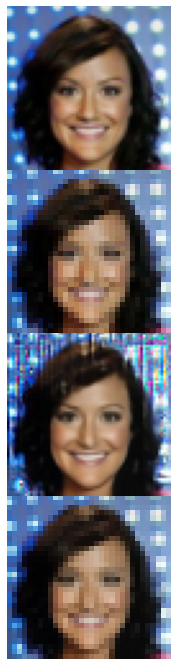

In [ ]:
#Ce print ne fonctionne que pour 1 image ! Pour plusieurs images il faut gérer le subplot et les ax comme un tableau 2D

fig, ax = plt.subplots(4, len(Z), figsize=(16, 12))
for i in range(len(Z)):
    ax[0].imshow(image[0])
    ax[0].axis('off')
    ax[1].imshow(np.transpose(denorm(y[0]).detach().cpu().numpy(), (1,2,0)))
    ax[1].axis('off')
    ax[2].imshow(np.transpose(denorm(img_[i].cpu()).detach().numpy(),(0,2,3,1))[0])
    ax[2].axis('off')
    ax[3].imshow(np.transpose(denorm(lower_reso(img_[i], r_s).cpu()).detach().numpy(),(0,2,3,1))[0])
    ax[3].axis('off')
plt.subplots_adjust(hspace=0.0, wspace=0.0)

In [ ]:
P = np.array(PSNR_)
SS = np.array(SSIM_)
S = np.array(SAD_)

print(P.mean(), P.std())
print(SS.mean(), SS.std())
print(S.mean(), S.std())

22.261241798400878 4.215331015829648
0.757920093998427 0.12430671629801471
0.97716594 0.019342458


##### Analysis

In [ ]:
PSNR_ = []
SSIM_ = []
SAD_ = []

In [ ]:
y = lower_reso(img.cuda(), r_s).detach()
ct = [[-1,-1,1,1]*16,[-1,-1,1,1]*16,[1,1,-1,-1]*16,[1,1,-1,-1]*16]*16
ct = torch.FloatTensor([ct, ct, ct]).cuda()

reg_f = nn.Hardtanh()

X = []

for b in range(batch_size):
    
    print("=============\n Image",b,":\n=============")
    
    for gamma in [0.0001]:
        
        x_ = (torch.rand(1,3,64,64)-0.5).cuda().requires_grad_()

        z_shapes = calc_z_shapes(3, 64, 32, 4)

        optimizer = torch.optim.Adam([x_], lr=0.1,)

        min_mse = np.Inf

        for e in range(epochs):
            
            z_ = model_single.forward(reg_f(x_))[-1]
            y_ = lower_reso_3(x_, r_s)

            reg_ = torch.tensor([0.0]).cuda()
            for i in range(4):
                reg_ += (z_[i]**2).sum()
        
            mse = ((y_.view(-1)-y[b].view(-1))**2).sum() + 1*gamma*reg_ + 0.0*gamma*(x_*ct).sum()**2

            if mse.item()<min_mse:
                x_min = x_
                min_mse = mse.item()
                
            if e%100==0:
                print(' - [Epoch :',e,'/',epochs,'] >>> MSE =',mse.item())

            mse.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        psnr = PSNR(denorm(img[b].unsqueeze(0)),denorm(x_min))
        ssim_ = SSIM(denorm(img[b].unsqueeze(0)),denorm(x_min))
        sad = SAD(denorm(img[b].unsqueeze(0)),denorm(x_min))

        PSNR_.append(psnr)
        SSIM_.append(ssim_)
        SAD_.append(sad)

        X.append(x_min)
        print('Min_MSE :',min_mse)
        print('PSNR :',psnr)
        print('SSIM :',ssim_)
        print('SAD :',sad)

 Image 0 :
 - [Epoch : 0 / 400 ] >>> MSE = 8454.4970703125
 - [Epoch : 100 / 400 ] >>> MSE = 19.834583282470703
 - [Epoch : 200 / 400 ] >>> MSE = 1.0830128192901611
 - [Epoch : 300 / 400 ] >>> MSE = 0.3530179560184479
Min_MSE : 0.33613258600234985
PSNR : 29.43242835998535
SSIM : 0.8926928445089185
SAD : 0.99731696
 Image 1 :
 - [Epoch : 0 / 400 ] >>> MSE = 8611.30078125
 - [Epoch : 100 / 400 ] >>> MSE = 19.66069793701172
 - [Epoch : 200 / 400 ] >>> MSE = 3.447070360183716
 - [Epoch : 300 / 400 ] >>> MSE = 0.35536596179008484
Min_MSE : 0.3314977288246155
PSNR : 30.73093605041504
SSIM : 0.9051620393066456
SAD : 0.9989195
 Image 2 :
 - [Epoch : 0 / 400 ] >>> MSE = 8926.046875
 - [Epoch : 100 / 400 ] >>> MSE = 20.842302322387695
 - [Epoch : 200 / 400 ] >>> MSE = 4.665390491485596
 - [Epoch : 300 / 400 ] >>> MSE = 0.5329790115356445
Min_MSE : 0.49223724007606506
PSNR : 30.239696502685547
SSIM : 0.9015613598026032
SAD : 0.99651754
 Image 3 :
 - [Epoch : 0 / 400 ] >>> MSE = 8886.7041015625
 -

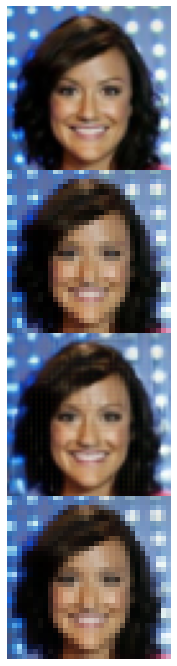

In [ ]:
#Ce print ne fonctionne que pour 1 image ! Pour plusieurs images il faut gérer le subplot et les ax comme un tableau 2D

fig, ax = plt.subplots(4, len(X), figsize=(16, 12))
for i in range(len(X)):
    ax[0].imshow(image[0])
    ax[0].axis('off')
    ax[1].imshow(np.transpose(denorm(y[0]).detach().cpu().numpy(), (1,2,0)))
    ax[1].axis('off')
    ax[2].imshow(np.transpose(denorm(X[i].cpu()).detach().numpy(),(0,2,3,1))[0])
    ax[2].axis('off')
    ax[3].imshow(np.transpose(denorm(lower_reso(X[i], r_s).cpu()).detach().numpy(),(0,2,3,1))[0])
    ax[3].axis('off')
plt.subplots_adjust(hspace=0.0, wspace=0.0)

In [ ]:
P = np.array(PSNR_)
SS = np.array(SSIM_)
S = np.array(SAD_)

print(P.mean(), P.std())
print(SS.mean(), SS.std())
print(S.mean(), S.std())

30.691329612731934 1.332574648604591
0.9171918945790103 0.02567780467351711
0.9977529 0.0012542888


### Hyper-Resolution

In [ ]:
def lower_reso(img,r_s):
    
    #pool = nn.MaxPool2d(r_s).cuda()
    pool = nn.AvgPool2d(r_s, stride=r_s).cuda()
    
    return pool(img)

###################################################

def lower_reso_3(img,r_s):
    
    conv = nn.Conv2d(1, 1, r_s, stride=r_s, bias=False).cuda()
    conv.weight.data.fill_(1/r_s**2)

    
    return conv(img.view(3,1,64,64)).view(3,16,16)

In [ ]:
epochs = 400

r_s = 4

##### Synthesis


In [ ]:
PSNR_ = []
SSIM_ = []
SAD_ = []

In [ ]:
y = lower_reso(img.cuda(), r_s).detach()
ct = [[-1,-1,-1,-1,1,1,1,1]*8,[-1,-1,-1,-1,1,1,1,1]*8,[-1,-1,-1,-1,1,1,1,1]*8,[-1,-1,-1,-1,1,1,1,1]*8,
      [1,1,1,1,-1,-1,-1,-1]*8,[1,1,1,1,-1,-1,-1,-1]*8,[1,1,1,1,-1,-1,-1,-1]*8,[1,1,1,1,-1,-1,-1,-1]*8]*8
ct = torch.FloatTensor([ct, ct, ct]).cuda()

Z = []

for b in range(batch_size):
    
    print("=============\n Image",b,":\n=============")
    
    for gamma in [0.0005]:
        
        z_sample = []
        z_shapes = calc_z_shapes(3, 64, 32, 4)
        for z in z_shapes:
            z_new = torch.randn(1, *z) * 0.0
            z_sample.append(z_new.cuda().requires_grad_())

        optimizer = torch.optim.Adam(z_sample, lr=0.1,)

        min_mse = np.Inf

        for e in range(epochs):
            
            x_ = model_single.reverse(z_sample)
            y_ = lower_reso_3(x_, r_s)

            reg_ = torch.tensor([0.0]).cuda()
            for i in range(4):
                reg_ += (z_sample[i]**2).sum()
        
            mse = ((y_.view(-1)-y[b].view(-1))**2).sum() + 10*gamma*reg_ + 2*gamma*(x_*ct).sum()**2

            if mse.item()<min_mse:
                z_min = z_sample
                min_mse = mse.item()
                
            if e%100==0:
                print(' - [Epoch :',e,'/',epochs,'] >>> MSE =',mse.item())

            mse.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        x_min = model_single.reverse(z_min)
        psnr = PSNR(denorm(img[b].unsqueeze(0)),denorm(x_min))
        ssim_ = SSIM(denorm(img[b].unsqueeze(0)),denorm(x_min))
        sad = SAD(denorm(img[b].unsqueeze(0)),denorm(x_min))

        PSNR_.append(psnr)
        SSIM_.append(ssim_)
        SAD_.append(sad)

        Z.append(z_min)
        print('Min_MSE :',min_mse)
        print('PSNR :',psnr)
        print('SSIM :',ssim_)
        print('SAD :',sad)

 Image 0 :
 - [Epoch : 0 / 400 ] >>> MSE = 79.460693359375
 - [Epoch : 100 / 400 ] >>> MSE = 2.780550479888916
 - [Epoch : 200 / 400 ] >>> MSE = 6.173120975494385
 - [Epoch : 300 / 400 ] >>> MSE = 3.945996046066284
Min_MSE : 1.2525873184204102
PSNR : 17.591718673706055
SSIM : 0.6149916378237067
SAD : 0.9750294
 Image 1 :
 - [Epoch : 0 / 400 ] >>> MSE = 31.511194229125977
 - [Epoch : 100 / 400 ] >>> MSE = 3.2917511463165283
 - [Epoch : 200 / 400 ] >>> MSE = 2.545011281967163
 - [Epoch : 300 / 400 ] >>> MSE = 1.2577563524246216
Min_MSE : 1.0220847129821777
PSNR : 15.739988327026367
SSIM : 0.555880993540438
SAD : 0.936917
 Image 2 :
 - [Epoch : 0 / 400 ] >>> MSE = 49.186073303222656
 - [Epoch : 100 / 400 ] >>> MSE = 3.0287392139434814
 - [Epoch : 200 / 400 ] >>> MSE = 1.6872771978378296
 - [Epoch : 300 / 400 ] >>> MSE = 3.5836710929870605
Min_MSE : 1.4925223588943481
PSNR : 16.86128807067871
SSIM : 0.6472874225602863
SAD : 0.9293463
 Image 3 :
 - [Epoch : 0 / 400 ] >>> MSE = 69.5504684448

In [ ]:
P = np.array(PSNR_)
SS = np.array(SSIM_)
S = np.array(SAD_)

print(P.mean(), P.std())
print(SS.mean(), SS.std())
print(S.mean(), S.std())

17.944132194519042 2.8100946328840593
0.5927238660737162 0.1195450147123819
0.95552987 0.027103875


In [ ]:
img_ = []
for i in range(len(Z)):
    
    img_.append(model_single.reverse(Z[i]))

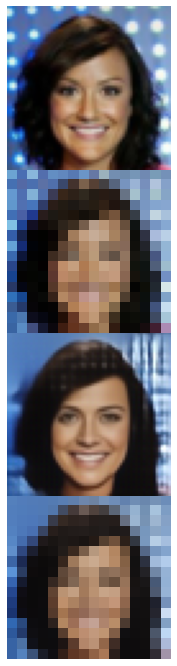

In [ ]:
#Ce print ne fonctionne que pour 1 image ! Pour plusieurs images il faut gérer le subplot et les ax comme un tableau 2D

fig, ax = plt.subplots(4, len(Z), figsize=(16, 12))
for i in range(len(Z)):
    ax[0].imshow(image[0])
    ax[0].axis('off')
    ax[1].imshow(np.transpose(denorm(y[0]).detach().cpu().numpy(), (1,2,0)))
    ax[1].axis('off')
    ax[2].imshow(np.transpose(denorm(img_[i].cpu()).detach().numpy(),(0,2,3,1))[0])
    ax[2].axis('off')
    ax[3].imshow(np.transpose(denorm(lower_reso(img_[i], r_s).cpu()).detach().numpy(),(0,2,3,1))[0])
    ax[3].axis('off')
plt.subplots_adjust(hspace=0.0, wspace=0.0)

In [ ]:
print(PSNR(img_[0],img))

20.037124633789062


##### Analysis

In [ ]:
PSNR_ = []
SSIM_ = []
SAD_ = []

In [ ]:
y = lower_reso(img.cuda(), r_s).detach()
ct = [[-1,-1,1,1]*16,[-1,-1,1,1]*16,[1,1,-1,-1]*16,[1,1,-1,-1]*16]*16
ct = torch.FloatTensor([ct, ct, ct]).cuda()

reg_f = nn.Hardtanh()

X = []

for b in range(batch_size):
    
    print("=============\n Image",b,":\n=============")
    
    for gamma in [0.0001]:
        
        x_ = (torch.rand(1,3,64,64)-0.5).cuda().requires_grad_()

        z_shapes = calc_z_shapes(3, 64, 32, 4)

        optimizer = torch.optim.Adam([x_], lr=0.1,)

        min_mse = np.Inf

        for e in range(epochs):
            
            z_ = model_single.forward(reg_f(x_))[-1]
            y_ = lower_reso_3(x_, r_s)

            reg_ = torch.tensor([0.0]).cuda()
            for i in range(4):
                reg_ += (z_[i]**2).sum()
        
            mse = ((y_.view(-1)-y[b].view(-1))**2).sum() + 0.1*gamma*reg_ + 8*gamma*(x_*ct).sum()**2

            if mse.item()<min_mse:
                x_min = x_
                min_mse = mse.item()
                
            if e%100==0:
                print(' - [Epoch :',e,'/',epochs,'] >>> MSE =',mse.item())

            mse.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        psnr = PSNR(denorm(img[b].unsqueeze(0)),denorm(x_min))
        ssim_ = SSIM(denorm(img[b].unsqueeze(0)),denorm(x_min))
        sad = SAD(denorm(img[b].unsqueeze(0)),denorm(x_min))

        PSNR_.append(psnr)
        SSIM_.append(ssim_)
        SAD_.append(sad)

        X.append(x_min)
        print('Min_MSE :',min_mse)
        print('PSNR :',psnr)
        print('SSIM :',ssim_)
        print('SAD :',sad)

 Image 0 :
 - [Epoch : 0 / 400 ] >>> MSE = 873.35595703125
 - [Epoch : 100 / 400 ] >>> MSE = 1.4075658321380615
 - [Epoch : 200 / 400 ] >>> MSE = 0.0773170217871666
 - [Epoch : 300 / 400 ] >>> MSE = 0.015725236386060715
Min_MSE : 0.010345777496695518
PSNR : 23.537891387939453
SSIM : 0.790472963518579
SAD : 0.99350137
 Image 1 :
 - [Epoch : 0 / 400 ] >>> MSE = 889.9208374023438
 - [Epoch : 100 / 400 ] >>> MSE = 1.4474737644195557
 - [Epoch : 200 / 400 ] >>> MSE = 0.049245528876781464
 - [Epoch : 300 / 400 ] >>> MSE = 0.02130044996738434
Min_MSE : 0.011988913640379906
PSNR : 24.520225524902344
SSIM : 0.813101287407204
SAD : 0.991337
 Image 2 :
 - [Epoch : 0 / 400 ] >>> MSE = 931.3298950195312
 - [Epoch : 100 / 400 ] >>> MSE = 2.036973237991333
 - [Epoch : 200 / 400 ] >>> MSE = 0.27902621030807495
 - [Epoch : 300 / 400 ] >>> MSE = 0.069694884121418
Min_MSE : 0.019871439784765244
PSNR : 25.071548461914062
SSIM : 0.7785747434320428
SAD : 0.9885637
 Image 3 :
 - [Epoch : 0 / 400 ] >>> MSE = 

In [ ]:
P = np.array(PSNR_)
SS = np.array(SSIM_)
S = np.array(SAD_)

print(P.mean(), P.std())
print(SS.mean(), SS.std())
print(S.mean(), S.std())

23.879458351135256 1.2927481785808783
0.7558206682613653 0.03583957114705882
0.9905488 0.003314854


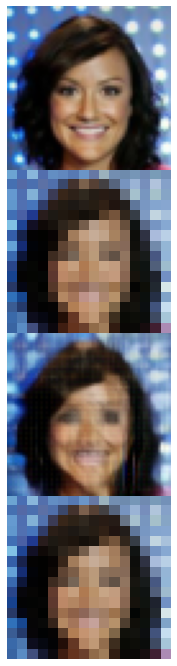

In [ ]:
#Ce print ne fonctionne que pour 1 image ! Pour plusieurs images il faut gérer le subplot et les ax comme un tableau 2D

fig, ax = plt.subplots(4, len(X), figsize=(16, 12))
for i in range(len(X)):
    ax[0].imshow(image[0])
    ax[0].axis('off')
    ax[1].imshow(np.transpose(denorm(y[0]).detach().cpu().numpy(), (1,2,0)))
    ax[1].axis('off')
    ax[2].imshow(np.transpose(denorm(x_min.cpu()).detach().numpy(),(0,2,3,1))[0])
    ax[2].axis('off')
    ax[3].imshow(np.transpose(denorm(lower_reso(x_min, r_s).cpu()).detach().numpy(),(0,2,3,1))[0])
    ax[3].axis('off')
plt.subplots_adjust(hspace=0.0, wspace=0.0)

### Blurry

In [36]:
def blurry(X,k):
    
    X_r = X[:,0,:,:].unsqueeze(1)
    X_g = X[:,1,:,:].unsqueeze(1)
    X_b = X[:,2,:,:].unsqueeze(1)
    if k%2 == 0:
        k+=1
    conv = nn.Conv2d(1,1,k,1,padding = int((k-1)/2), bias=False).cuda()
    conv.weight.data.fill_(1/(k*k))
    blurry_img_r = conv(X_r)
    blurry_img_g = conv(X_g)
    blurry_img_b = conv(X_b)
    
    blurry_img = torch.cat((blurry_img_r,blurry_img_g,blurry_img_b),1).cuda()
    
    return blurry_img

def blurry_2(img,k):

    b, c, h, w = img.shape
    conv = nn.Conv2d(1, 1, k, stride=1, padding=int((k-1)/2), bias=False).cuda()
    conv.weight.data.fill_(1/(k*k))
    
    return conv(img.view(c,b,h,w)).view(b,c,h,w)

In [40]:
epochs = 1000

k_blurry = 7

Initialization $z_0=0_{\mathbb{R}^n}$ acts as a regularization term because the latent space of the prior is such that we have a high-likelihood here.


##### Synthesis

In [41]:
PSNR_ = []
SSIM_ = []
SAD_ = []

In [42]:

ct = [[-1,1]*32,[1,-1]*32]*32
ct = torch.FloatTensor([ct, ct, ct]).cuda()

Z = []

for b in range(batch_size):

    y = blurry_2(img[b].unsqueeze(0).cuda(),k_blurry).detach()
    
    print("=============\n Image",b,":\n=============")
    
    for gamma in [0.001]:
        
        z_sample = []
        z_shapes = calc_z_shapes(3, 64, 32, 4)
        for z in z_shapes:
            z_new = torch.randn(1, *z) * 0.0
            z_sample.append(z_new.cuda().requires_grad_())

        optimizer = torch.optim.Adam(z_sample, lr=0.1,)

        min_mse = np.Inf

        for e in range(epochs):
            
            x_ = model_single.reverse(z_sample)
            y_ = blurry_2(x_, k_blurry)


            reg_ = torch.tensor([0.0]).cuda()
            for i in range(4):
                reg_ += (z_sample[i]**2).sum()
        
            mse = ((y_.view(-1)-y.view(-1))**2).sum() + 0.1*gamma*reg_  #+ 0*gamma*(x_*ct).sum()**2

            if mse.item()<min_mse:
                z_min = z_sample
                min_mse = mse.item()
                
            if e%100==0:
                print(' - [Epoch :',e,'/',epochs,'] >>> MSE =',mse.item())

            mse.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        x_min = model_single.reverse(z_min)
        psnr = PSNR(denorm(img[b].unsqueeze(0)),denorm(x_min))
        ssim_ = SSIM(denorm(img[b].unsqueeze(0)),denorm(x_min))
        sad = SAD(denorm(img[b].unsqueeze(0)),denorm(x_min))

        PSNR_.append(psnr)
        SSIM_.append(ssim_)
        SAD_.append(sad)

        Z.append(z_min)
        print('Min_MSE :',min_mse)
        print('PSNR :',psnr)
        print('SSIM :',ssim_)
        print('SAD :',sad)

 Image 0 :
 - [Epoch : 0 / 1000 ] >>> MSE = 1125.6357421875
 - [Epoch : 100 / 1000 ] >>> MSE = 12.359505653381348
 - [Epoch : 200 / 1000 ] >>> MSE = 6.156619071960449
 - [Epoch : 300 / 1000 ] >>> MSE = 4.266321182250977
 - [Epoch : 400 / 1000 ] >>> MSE = 3.345592975616455
 - [Epoch : 500 / 1000 ] >>> MSE = 2.7894062995910645
 - [Epoch : 600 / 1000 ] >>> MSE = 2.398350238800049
 - [Epoch : 700 / 1000 ] >>> MSE = 2.0947914123535156
 - [Epoch : 800 / 1000 ] >>> MSE = 1.8344346284866333
 - [Epoch : 900 / 1000 ] >>> MSE = 1.5829343795776367
Min_MSE : 1.4115943908691406
PSNR : 24.6001033782959
SSIM : 0.6159183267117884
SAD : 0.9898565
 Image 1 :
 - [Epoch : 0 / 1000 ] >>> MSE = 760.6768188476562
 - [Epoch : 100 / 1000 ] >>> MSE = 12.819297790527344
 - [Epoch : 200 / 1000 ] >>> MSE = 5.580648422241211
 - [Epoch : 300 / 1000 ] >>> MSE = 3.4410784244537354
 - [Epoch : 400 / 1000 ] >>> MSE = 2.4813108444213867
 - [Epoch : 500 / 1000 ] >>> MSE = 1.8089585304260254
 - [Epoch : 600 / 1000 ] >>> MSE

In [43]:
img_ = []
for i in range(len(Z)):
    
    img_.append(model_single.reverse(Z[i]))

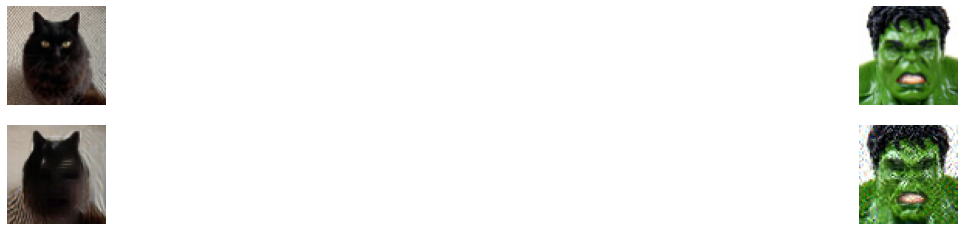

In [44]:
fig, ax = plt.subplots(2, len(Z), figsize=(28, 4))
for i in range(len(Z)):

    ax[0][i].imshow(image[i])
    ax[0][i].axis('off')
    ax[1][i].imshow(np.transpose(denorm(img_[i].cpu()).detach().numpy(),(0,2,3,1))[0])
    ax[1][i].axis('off')

In [ ]:
#Ce print ne fonctionne que pour 1 image ! Pour plusieurs images il faut gérer le subplot et les ax comme un tableau 2D

fig, ax = plt.subplots(4, len(Z), figsize=(16, 12))
for i in range(len(Z)):
    ax[0].imshow(image[i])
    ax[0].axis('off')
    ax[1].imshow(np.transpose(denorm(y[i]).detach().cpu().numpy(), (1,2,0)))
    ax[1].axis('off')
    ax[2].imshow(np.transpose(denorm(img_[i].cpu()).detach().numpy(),(0,2,3,1))[0])
    ax[2].axis('off')
    ax[3].imshow(np.transpose(denorm(blurry_2(img_[i], k_blurry).cpu()).detach().numpy(),(0,2,3,1))[0])
    ax[3].axis('off')
plt.subplots_adjust(hspace=0.0, wspace=0.0)

In [ ]:
P = np.array(PSNR_)
SS = np.array(SSIM_)
S = np.array(SAD_)

print(P.mean(), P.std())
print(SS.mean(), SS.std())
print(S.mean(), S.std())

nan nan
nan nan
nan nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys


##### Analysis

In [45]:
PSNR_ = []
SSIM_ = []
SAD_ = []

In [54]:

ct = [[-1,-1,1,1]*16,[-1,-1,1,1]*16,[1,1,-1,-1]*16,[1,1,-1,-1]*16]*16
ct = torch.FloatTensor([ct, ct, ct]).cuda()

reg_f = nn.Hardtanh()

X = []
y = []

for b in range(batch_size):
    
    y.append(blurry_2(img[b].unsqueeze(0).cuda(),k_blurry).detach())

    print("=============\n Image",b,":\n=============")
    
    for gamma in [0.0001]:
        
        x_ = (torch.rand(1,3,64,64)-0.5).cuda().requires_grad_()

        z_shapes = calc_z_shapes(3, 64, 32, 4)

        optimizer = torch.optim.Adam([x_], lr=0.1,)

        min_mse = np.Inf

        for e in range(epochs):
            
            z_ = model_single.forward(reg_f(x_))[-1]
            y_ = blurry_2(x_, k_blurry)

            reg_ = torch.tensor([0.0]).cuda()
            for i in range(4):
                reg_ += (z_[i]**2).sum()
        
            mse = ((y_.view(-1)-y[b].view(-1))**2).sum() + 0.1*gamma*reg_ #+ 8*gamma*(x_*ct).sum()**2

            if mse.item()<min_mse:
                x_min = x_
                min_mse = mse.item()
                
            if e%100==0:
                print(' - [Epoch :',e,'/',epochs,'] >>> MSE =',mse.item())

            mse.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        psnr = PSNR(denorm(img[b].unsqueeze(0)),denorm(x_min))
        ssim_ = SSIM(denorm(img[b].unsqueeze(0)),denorm(x_min))
        sad = SAD(denorm(img[b].unsqueeze(0)),denorm(x_min))

        PSNR_.append(psnr)
        SSIM_.append(ssim_)
        SAD_.append(sad)

        X.append(x_min)
        print('Min_MSE :',min_mse)
        print('PSNR :',psnr)
        print('SSIM :',ssim_)
        print('SAD :',sad)

 Image 0 :
 - [Epoch : 0 / 1000 ] >>> MSE = 1950.03857421875
 - [Epoch : 100 / 1000 ] >>> MSE = 0.48619794845581055
 - [Epoch : 200 / 1000 ] >>> MSE = 0.05321411043405533
 - [Epoch : 300 / 1000 ] >>> MSE = 0.04289232939481735
 - [Epoch : 400 / 1000 ] >>> MSE = 0.04022935777902603
 - [Epoch : 500 / 1000 ] >>> MSE = 0.03901167958974838
 - [Epoch : 600 / 1000 ] >>> MSE = 0.03853635489940643
 - [Epoch : 700 / 1000 ] >>> MSE = 0.0383257195353508
 - [Epoch : 800 / 1000 ] >>> MSE = 0.03828882426023483
 - [Epoch : 900 / 1000 ] >>> MSE = 0.03825319558382034
Min_MSE : 0.03816037252545357
PSNR : 28.510173797607422
SSIM : 0.803576998371021
SAD : 0.9958823
 Image 1 :
 - [Epoch : 0 / 1000 ] >>> MSE = 1662.25439453125
 - [Epoch : 100 / 1000 ] >>> MSE = 0.6910128593444824
 - [Epoch : 200 / 1000 ] >>> MSE = 0.1281495988368988
 - [Epoch : 300 / 1000 ] >>> MSE = 0.1052437424659729
 - [Epoch : 400 / 1000 ] >>> MSE = 0.09851907193660736
 - [Epoch : 500 / 1000 ] >>> MSE = 0.09663021564483643
 - [Epoch : 600

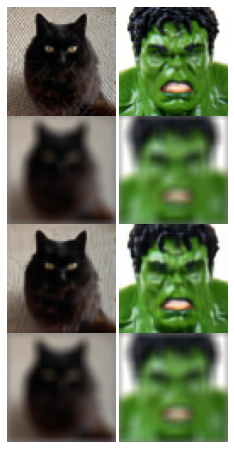

In [60]:
#Ce print ne fonctionne que pour 1 image ! Pour plusieurs images il faut gérer le subplot et les ax comme un tableau 2D

fig, ax = plt.subplots(4, len(X), figsize=(4, 8))
for i in range(len(X)):
    ax[0][i].imshow(image[i])
    ax[0][i].axis('off')
    ax[1][i].imshow(np.transpose(denorm(y[i]).detach().cpu().numpy(), (0,2,3,1))[0])
    ax[1][i].axis('off')
    ax[2][i].imshow(np.transpose(denorm(X[i].cpu()).detach().numpy(),(0,2,3,1))[0])
    ax[2][i].axis('off')
    ax[3][i].imshow(np.transpose(denorm(blurry_2(X[i], k_blurry).cpu()).detach().numpy(),(0,2,3,1))[0])
    ax[3][i].axis('off')
plt.subplots_adjust(hspace=0.0, wspace=0.0)

In [59]:
y[0].shape

torch.Size([1, 3, 64, 64])

In [ ]:
P = np.array(PSNR_)
SS = np.array(SSIM_)
S = np.array(SAD_)

print(P.mean(), P.std())
print(SS.mean(), SS.std())
print(S.mean(), S.std())

32.157152290344236 1.5596897446636464
0.9362683625249155 0.014174461261775535
0.99847955 0.0008338723


### y = Ax + n

In [ ]:
m = 32*32*3

epochs = 800

In [ ]:
A = torch.Tensor(np.random.normal(0, 1/m, (batch_size, m, 64*64*3))).cuda()
etha = torch.Tensor(np.random.normal(0, 0.1/m, (batch_size, m))).cuda().detach()

##### Synthesis

In [ ]:
Y = []
Z = []

for b in range(batch_size):
    
    y = torch.mm(A[b],img[b].cuda().view(-1).unsqueeze(-1)).detach()#+etha
    Y.append(y)
    print("=============\n Image",b,":\n=============")
    
    for gamma in [0.0005]:
        
        z_sample = []
        z_shapes = calc_z_shapes(3, 64, 32, 4)
        for z in z_shapes:
            z_new = torch.randn(1, *z) * 0.0
            z_sample.append(z_new.cuda().requires_grad_())

        optimizer = torch.optim.Adam(z_sample, lr=0.1,)

        min_mse = np.Inf

        for e in range(epochs):
            
            x_ = model_single.reverse(z_sample)
            y_ = torch.mm(A[b],x_.view(-1).unsqueeze(-1)) #+ torch.Tensor(np.random.normal(0, 0.1/m, (batch_size, m))).cuda()

            reg_ = torch.tensor([0.0]).cuda()
            for i in range(4):
                reg_ += (z_sample[i]**2).sum()
        
            mse = ((y_.view(-1)-y.view(-1))**2).sum() + 0.1*gamma*reg_

            if mse.item()<min_mse:
                z_min = z_sample
                min_mse = mse.item()
                
            if e%100==0:
                print(' - [Epoch :',e,'/',epochs,'] >>> MSE =',mse.item())

            mse.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        Z.append(z_min)
        print('Min_MSE :',min_mse)

 Image 0 :
 - [Epoch : 0 / 800 ] >>> MSE = 0.7980285286903381
 - [Epoch : 100 / 800 ] >>> MSE = 0.054269034415483475
 - [Epoch : 200 / 800 ] >>> MSE = 0.034719642251729965
 - [Epoch : 300 / 800 ] >>> MSE = 0.030804112553596497
 - [Epoch : 400 / 800 ] >>> MSE = 0.0293588750064373
 - [Epoch : 500 / 800 ] >>> MSE = 0.029129881411790848
 - [Epoch : 600 / 800 ] >>> MSE = 0.04116230458021164
 - [Epoch : 700 / 800 ] >>> MSE = 0.02734263241291046
Min_MSE : 0.024590667337179184


In [ ]:
img_ = []
for i in range(len(Z)):

    img_.append(model_single.reverse(Z[i]))

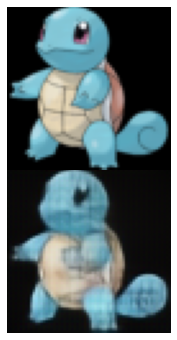

In [ ]:
fig, ax = plt.subplots(2, len(Z), figsize=(16, 6  ))
for i in range(len(Z)):
    ax[0].imshow(image[0])
    ax[0].axis('off')
    ax[1].imshow(np.transpose(denorm(img_[i].cpu()).detach().numpy(),(0,2,3,1))[0])
    ax[1].axis('off')

plt.subplots_adjust(hspace=0.0, wspace=0.0)

##### Analysis

In [ ]:
reg_f = nn.Hardtanh()
Y = []
X = []

for b in range(batch_size):
    
    y = torch.mm(A[b],img[b].cuda().view(-1).unsqueeze(-1)).detach()
    Y.append(y)
    
    print("=============\n Image",b,":\n=============")
    
    for gamma in [0.0000]:
        
        #x_ = (torch.rand(1,3,64,64)-0.5).cuda().requires_grad_()            ### Random Initialization
        
        z_0 = []
        z_shapes = calc_z_shapes(3, 64, 32, 4)
        for z in z_shapes:
            z_new = torch.zeros(1, *z)
            z_0.append(z_new.cuda())

        x_ = model_single.reverse(z_0).detach().cuda().requires_grad_()      ### Initialisation at G(0)


        optimizer = torch.optim.Adam([x_], lr=0.1,)

        min_mse = np.Inf

        for e in range(epochs):
            
            z_ = model_single.forward(reg_f(x_))[-1]
            y_ = torch.mm(A[b],x_.view(-1).unsqueeze(-1))

            reg_ = torch.tensor([0.0]).cuda()
            for i in range(4):
                reg_ += (z_[i]**2).sum()
        
            mse = ((y_.view(-1)-y[b].view(-1))**2).sum() + 1*gamma*reg_

            if mse.item()<min_mse:
                x_min = x_
                min_mse = mse.item()
                
            if e%100==0:
                print(' - [Epoch :',e,'/',epochs,'] >>> MSE =',mse.item())

            mse.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        X.append(x_min)
        print('Min_MSE :',min_mse)

 Image 0 :
 - [Epoch : 0 / 800 ] >>> MSE = 1.0329022407531738
 - [Epoch : 100 / 800 ] >>> MSE = 8.896314284356777e-06
 - [Epoch : 200 / 800 ] >>> MSE = 2.888236594333904e-10
 - [Epoch : 300 / 800 ] >>> MSE = 9.612449725082683e-14
 - [Epoch : 400 / 800 ] >>> MSE = 9.993048055711995e-14
 - [Epoch : 500 / 800 ] >>> MSE = 1.7942689112260268e-08
 - [Epoch : 600 / 800 ] >>> MSE = 2.591044108157803e-07
 - [Epoch : 700 / 800 ] >>> MSE = 9.26480296925547e-08
Min_MSE : 8.079648061709577e-14


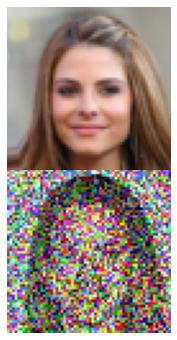

In [ ]:
fig, ax = plt.subplots(2, len(X), figsize=(16, 6  ))
for i in range(len(X)):
    ax[0].imshow(image[0])
    ax[0].axis('off')
    ax[1].imshow(np.transpose(denorm(X[i].cpu()).detach().numpy(),(0,2,3,1))[0])
    ax[1].axis('off')

plt.subplots_adjust(hspace=0.0, wspace=0.0)

### Inpainting

In [16]:
# Random Mask

def create_mask(size, p, batch_size):
    
    M = []
    
    for i in range(batch_size):
        m, n = size, size
        N = int(p*m*n)
        mask = np.random.permutation([0]*(m*n-N)+[1]*N)
        M.append(mask)

    M = torch.Tensor(M).view(batch_size, 1, m, n)
    M = torch.cat([M, M, M], dim=1)
    
    return M

In [17]:
# Centered Mask

def create_mask_2(size, p, batch_size):
    
    M = []
    
    for i in range(batch_size):
        m, n = size, size
        N = int(p*m)
        mask = np.array([[1]*64]*64)
        for j in range(int(32-N/2), int(32+N/2)):
            for k in range(int(32-N/2), int(32+N/2)):
                mask[j,k] = 0
        M.append(mask)

    M = torch.Tensor(M).view(batch_size, 1, m, n)
    M = torch.cat([M, M, M], dim=1)
    
    return M

In [29]:
epochs = 1000

M = create_mask(64, 0.4, batch_size).cuda()
#M = create_mask_2(64, 0.33, batch_size).cuda()

##### Synthesis

In [19]:
PSNR_ = []
SSIM_ = []
SAD_ = []

In [20]:
y = (M*img.cuda()).detach()

Z = []

for b in range(batch_size):
    
    print("=============\n Image",b,":\n=============")
    
    
    for gamma in [0.0004]:
        
        z_sample = []
        z_shapes = calc_z_shapes(3, 64, 32, 4)
        for z in z_shapes:
            z_new = torch.randn(1, *z) * 0.0
            z_sample.append(z_new.cuda().requires_grad_())

        optimizer = torch.optim.Adam(z_sample, lr=0.1,)
 
        min_mse = np.Inf

        for e in range(epochs):
            
            reg_ = torch.tensor([0.0]).cuda()
            for i in range(4):
                reg_ += (z_sample[i]**2).sum() 

            x_ = model_single.reverse(z_sample)
            y_ = M[b,:,:,:]*x_
            mse = ((y_.view(-1)-y[b].view(-1))**2).sum() + 1*gamma*reg_

            if mse.item()<min_mse:
                z_min = z_sample
                min_mse = mse.item()
                
            if e%100==0:
                print(' - [Epoch :',e,'/',epochs,'] >>> MSE =',mse.item())

            mse.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        x_min = model_single.reverse(z_min)
        psnr = PSNR(denorm(img[b].unsqueeze(0)),denorm(x_min))
        ssim_ = SSIM(denorm(img[b].unsqueeze(0)),denorm(x_min))
        sad = SAD(denorm(img[b].unsqueeze(0)),denorm(x_min))

        PSNR_.append(psnr)
        SSIM_.append(ssim_)
        SAD_.append(sad)

        Z.append(z_min)
        print('Min_MSE :',min_mse)
        print('PSNR :',psnr)
        print('SSIM :',ssim_)
        print('SAD :',sad)

 Image 0 :
 - [Epoch : 0 / 1000 ] >>> MSE = 1074.512939453125
 - [Epoch : 100 / 1000 ] >>> MSE = 32.53535461425781
 - [Epoch : 200 / 1000 ] >>> MSE = 16.913284301757812
 - [Epoch : 300 / 1000 ] >>> MSE = 9.61747932434082
 - [Epoch : 400 / 1000 ] >>> MSE = 6.995276927947998
 - [Epoch : 500 / 1000 ] >>> MSE = 5.6906843185424805
 - [Epoch : 600 / 1000 ] >>> MSE = 4.8473663330078125
 - [Epoch : 700 / 1000 ] >>> MSE = 4.260663032531738
 - [Epoch : 800 / 1000 ] >>> MSE = 4.423873424530029
 - [Epoch : 900 / 1000 ] >>> MSE = 3.4072580337524414
Min_MSE : 3.221844434738159
PSNR : 29.34290885925293
SSIM : 0.8609185587231162
SAD : 0.9966018
 Image 1 :
 - [Epoch : 0 / 1000 ] >>> MSE = 1214.5875244140625
 - [Epoch : 100 / 1000 ] >>> MSE = 47.97459411621094
 - [Epoch : 200 / 1000 ] >>> MSE = 18.912796020507812
 - [Epoch : 300 / 1000 ] >>> MSE = 10.227818489074707
 - [Epoch : 400 / 1000 ] >>> MSE = 7.057879447937012
 - [Epoch : 500 / 1000 ] >>> MSE = 5.966033935546875
 - [Epoch : 600 / 1000 ] >>> MSE 

In [21]:
img_ = []
for i in range(len(Z)):
    #z = [Z[i][0].cpu(),Z[i][1].cpu(),Z[i][2].cpu(),Z[i][3].cpu()]
    img_.append(model_single.reverse(Z[i]))

In [22]:
P = np.array(PSNR_)
SS = np.array(SSIM_)
S = np.array(SAD_)

print(P.mean(), P.std())
print(SS.mean(), SS.std())
print(S.mean(), S.std())

26.480112075805664 2.8627967834472656
0.8658615268073935 0.004942968084277299
0.9936458 0.0029560328


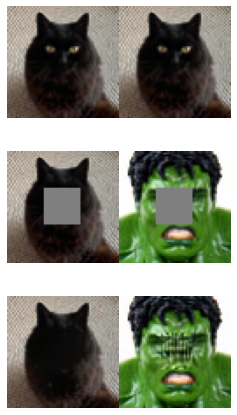

In [28]:
fig, ax = plt.subplots(3, len(Z), figsize=(4, 8))
for i in range(len(Z)):
    ax[0][i].imshow(image[0])
    ax[0][i].axis('off')
    ax[1][i].imshow(np.transpose(denorm(y[i]).detach().cpu().numpy(), (1,2,0)))
    ax[1][i].axis('off')
    ax[2][i].imshow(np.transpose(denorm(img_[i].cpu()).detach().numpy(),(0,2,3,1))[0])
    ax[2][i].axis('off')

plt.subplots_adjust(hspace=0.0, wspace=0.0)

##### Analysis


In [30]:
PSNR_ = []
SSIM_ = []
SAD_ = []

In [31]:
reg_f = nn.Hardtanh()
y = (M*img.cuda()).detach()

X = []

for b in range(batch_size):
    
    print("=============\n Image",b,":\n=============")
    
    for gamma in [0.0005]:
        
        #x_ = (torch.rand(1,3,64,64)-0.5).cuda().requires_grad_()            ### Random Initialization
        
        z_0 = []
        z_shapes = calc_z_shapes(3, 64, 32, 4)
        for z in z_shapes:
            z_new = torch.zeros(1, *z)
            z_0.append(z_new.cuda())

        x_ = model_single.reverse(z_0).detach().cuda().requires_grad_()      ### Initialisation at G(0)


        optimizer = torch.optim.Adam([x_], lr=0.1,)

        min_mse = np.Inf

        for e in range(epochs):
            
            z_ = model_single.forward(reg_f(x_))[-1]
            y_ = M[b,:,:,:]*x_

            reg_ = torch.tensor([0.0]).cuda()
            for i in range(4):
                reg_ += (z_[i]**2).sum()
        
            mse = ((y_.view(-1)-y[b].view(-1))**2).sum() + 1*gamma*reg_

            if mse.item()<min_mse:
                x_min = x_
                min_mse = mse.item()
                
            if e%100==0:
                print(' - [Epoch :',e,'/',epochs,'] >>> MSE =',mse.item())

            mse.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        psnr = PSNR(denorm(img[b].unsqueeze(0)),denorm(x_min))
        ssim_ = SSIM(denorm(img[b].unsqueeze(0)),denorm(x_min))
        sad = SAD(denorm(img[b].unsqueeze(0)),denorm(x_min))

        PSNR_.append(psnr)
        SSIM_.append(ssim_)
        SAD_.append(sad)

        X.append(x_min)
        print('Min_MSE :',min_mse)
        print('PSNR :',psnr)
        print('SSIM :',ssim_)
        print('SAD :',sad)

 Image 0 :
 - [Epoch : 0 / 1000 ] >>> MSE = 594.9015502929688
 - [Epoch : 100 / 1000 ] >>> MSE = 7.207793235778809
 - [Epoch : 200 / 1000 ] >>> MSE = 4.12723445892334
 - [Epoch : 300 / 1000 ] >>> MSE = 4.305610656738281
 - [Epoch : 400 / 1000 ] >>> MSE = 4.613077640533447
 - [Epoch : 500 / 1000 ] >>> MSE = 5.475783348083496
 - [Epoch : 600 / 1000 ] >>> MSE = 6.750062465667725
 - [Epoch : 700 / 1000 ] >>> MSE = 8.655023574829102
 - [Epoch : 800 / 1000 ] >>> MSE = 10.700468063354492
 - [Epoch : 900 / 1000 ] >>> MSE = 12.607694625854492
Min_MSE : 3.836735248565674
PSNR : 26.088220596313477
SSIM : 0.7396538888344805
SAD : 0.9928023
 Image 1 :
 - [Epoch : 0 / 1000 ] >>> MSE = 563.7892456054688
 - [Epoch : 100 / 1000 ] >>> MSE = 10.709218978881836
 - [Epoch : 200 / 1000 ] >>> MSE = 8.052862167358398
 - [Epoch : 300 / 1000 ] >>> MSE = 8.795589447021484
 - [Epoch : 400 / 1000 ] >>> MSE = 9.853727340698242
 - [Epoch : 500 / 1000 ] >>> MSE = 11.26133918762207
 - [Epoch : 600 / 1000 ] >>> MSE = 1

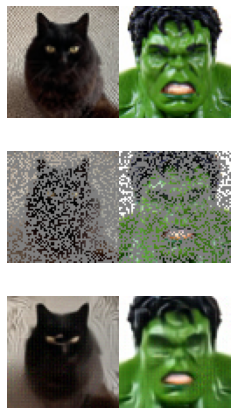

In [34]:
fig, ax = plt.subplots(3, len(X), figsize=(4, 8))
for i in range(len(X)):
    ax[0][i].imshow(image[i])
    ax[0][i].axis('off')
    ax[1][i].imshow(np.transpose(denorm(y[i]).detach().cpu().numpy(), (1,2,0)))
    ax[1][i].axis('off')
    ax[2][i].imshow(np.transpose(denorm(X[i].cpu()).detach().numpy(),(0,2,3,1))[0])
    ax[2][i].axis('off')

plt.subplots_adjust(hspace=0.0, wspace=0.0)

In [ ]:
P = np.array(PSNR_)
SS = np.array(SSIM_)
S = np.array(SAD_)

print(P.mean(), P.std())
print(SS.mean(), SS.std())
print(S.mean(), S.std())

26.498145027160646 3.2897895062744653
0.8995511598163921 0.034338664656525617
0.9926151 0.0094628325


### Other tests


In [ ]:
lz = torch.tensor([])
for i in range(4):
    lz = torch.cat([lz, (Z[0][i].cpu().detach().view(-1))])
        
lz = np.array(lz)

In [ ]:
mu = lz.mean()
sigma = lz.std()

x = np.linspace(-20, 20, num=len(lz))
y = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-1/2*((x-mu)/sigma)**2)

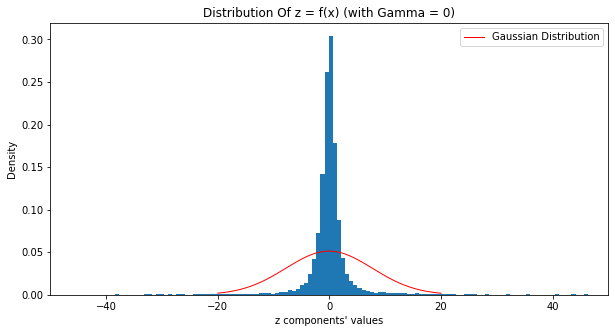

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.figure()
plt.hist(lz, bins = 500, density = True)
plt.title('Distribution Of z = f(x) (with Gamma = 0)')
plt.plot(x, y, color='red', lw=1, label='Gaussian Distribution')
plt.xlabel('z components\' values')
plt.ylabel('Density')
plt.xlim([-50, 50])
plt.legend(loc="upper right")
plt.show()

In [ ]:
lz2 = torch.tensor([])
for i in range(4):
    lz2 = torch.cat([lz2, (Z[-1][i].cpu().detach().view(-1))])
        
lz2 = np.array(lz2)

In [ ]:
mu2 = lz2.mean()
sigma2 = lz2.std()

x2 = np.linspace(-20, 20, num=len(lz2))
y2 = 1/(sigma2*np.sqrt(2*np.pi))*np.exp(-1/2*((x2-mu2)/sigma2)**2)

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.figure()
plt.hist(lz, bins = 500, density = True)
plt.title('Distribution Of z = f(x) (with Gamma = 0.1)')
plt.plot(x, y, color='red', lw=1, label='Gaussian Distribution')
plt.xlabel('z components\' values')
plt.ylabel('Density')
#plt.xlim([-50, 50])
plt.legend(loc="upper right")
plt.show()